In [58]:

import os
import shutil
import time
from collections import defaultdict


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from SALib.analyze import sobol


from ema_workbench import (
    Model, Policy, Scenario, MultiprocessingEvaluator,
    ema_logging
)
from ema_workbench.analysis import (
    feature_scoring, parcoords, pairs_plotting, prim
)
from ema_workbench.em_framework.evaluators import (
    BaseEvaluator, perform_experiments
)
from ema_workbench.em_framework.optimization import (
    ArchiveLogger, EpsilonProgress, EpsNSGAII,
    HyperVolume, epsilon_nondominated, to_problem
)
from ema_workbench.em_framework.outcomes import ScalarOutcome
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from pandas.api.types import is_numeric_dtype


from ema_workbench import Constraint
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import dimensional_stacking
from pandas.api.types import is_numeric_dtype, is_categorical_dtype

def get_do_nothing_dict():
    return {l.name: 0 for l in model.levers}





In [3]:
#Start with running baseline scenario
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(3)

    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        baseline = Policy("do_nothing", **get_do_nothing_dict())
        policies = [baseline]

        results = evaluator.perform_experiments(scenarios=1000, policies=policies)
        baseline_experiments, baseline_outcomes = results


INFO | pool started with 7 workers
INFO | performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|██████████████████████████████████████| 1000/1000 [02:39<00:00,  6.28it/s]
INFO | experiments finished
INFO | terminating pool


In [60]:
# Your lever names — make sure they exactly match model.levers
rfr_lever_names = [f"{area}_RfR {i}" for area in range(5) for i in range(3)]

# Constraint function
def max_one_rfr_total(*args):
    total = float(np.sum(args))  # ensures scalar
    violation = 0
    for i in range(0, len(args), 3):
        group_total = float(np.sum(args[i:i+3]))
        if group_total > 1:
            violation += group_total - 1
    return violation

# Constraint object
max_one_rfr_constraint = Constraint(
    "max_one_rfr_total",
    function=max_one_rfr_total,
    parameter_names=rfr_lever_names)

## Running and showing the model

In [62]:
if __name__ == "__main__":

    # --- Load your model ---
    model, planning_steps = get_model_for_problem_formulation(3)



    reference_values = {
        "Bmax": 175,
        "Brate": 1.5,
        "pfail": 0.5,
        "discount rate 0": 3.5,
        "discount rate 1": 3.5,
        "discount rate 2": 3.5,
        "ID flood wave shape": 4,
    }
    scen1 = {}

    for key in model.uncertainties:
        name_split = key.name.split("_")

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario("reference", **scen1)


    convergence_metrics = [

    EpsilonProgress(),
]

    espilon = [0.01] * len(model.outcomes)


    nfe = 1000

    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            epsilons=espilon,
            convergence=convergence_metrics,constraints=[max_one_rfr_constraint], reference=ref_scenario,

        )

[MainProcess/INFO] pool started with 8 workers

  0%|                                                 | 0/1000 [00:00<?, ?it/s]INFO | EpsNSGAII starting

 40%|███████████████▌                       | 400/1000 [00:44<01:06,  8.97it/s]INFO | EpsNSGAII running; NFE Complete: 500, Elapsed Time: 0:00:55.963622

 90%|███████████████████████████████████    | 900/1000 [01:42<00:11,  8.57it/s]INFO | EpsNSGAII running; NFE Complete: 1000, Elapsed Time: 0:01:55.682316
INFO | EpsNSGAII finished; Total NFE: 1000, Elapsed Time: 0:01:55.683010

100%|██████████████████████████████████████| 1000/1000 [01:55<00:00,  8.64it/s]
[MainProcess/INFO] optimization completed, found 57 solutions
[MainProcess/INFO] terminating pool


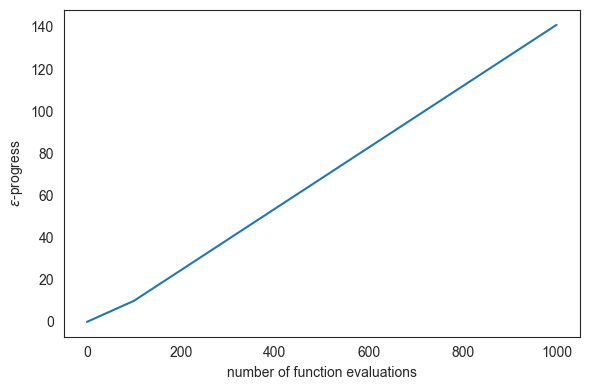

In [66]:
fig, ax1 = plt.subplots(figsize=(6, 4))  # no ncols=2

ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel(r'$\epsilon$-progress')
ax1.set_xlabel('number of function evaluations')
plt.savefig("convergence enkel MORDM.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()



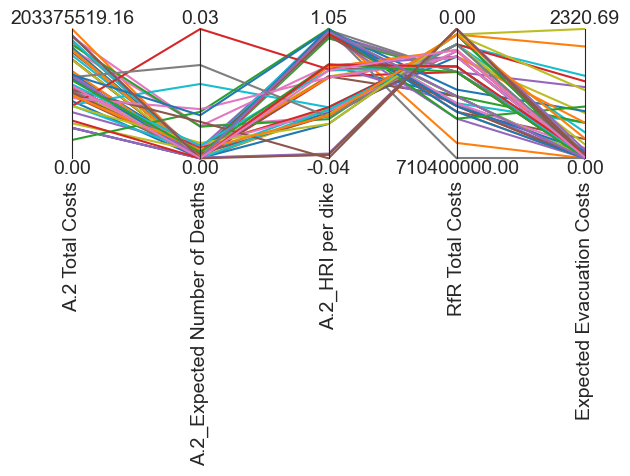

<Figure size 1400x1000 with 0 Axes>

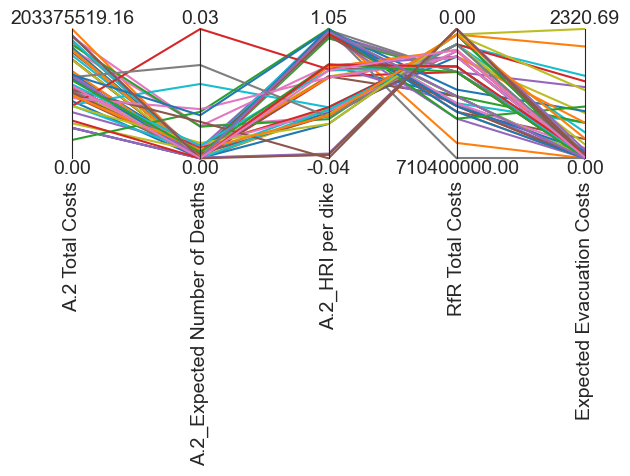

In [67]:
data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths', 'RfR Total Costs',"Expected Evacuation Costs"]] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
    # Set larger figure size (wider and taller)
plt.figure(figsize=(14, 10))  # width=12 inches, height=8 inches

# Generate parallel axes with your limits
paraxes = parcoords.ParallelAxes(limits)

# Plot the data
paraxes.plot(data)

# Invert specific axis
paraxes.invert_axis("RfR Total Costs")

# Save the plot
plt.savefig("mordm_parallel coordinates all.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [68]:
logical = (
    (results["A.2 Total Costs"] < 7e7) &

    (results["A.2_HRI per dike"] > 0.7))



np.sum(logical)

np.int64(3)

/var/folders/sp/3r57ckwj0f59wpwykds8r5040000gn/T/ipykernel_28432/959764074.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_1["policy"] = results_1.index  # Automatically uses 16, 17, 18 in your case


<Figure size 1400x1000 with 0 Axes>

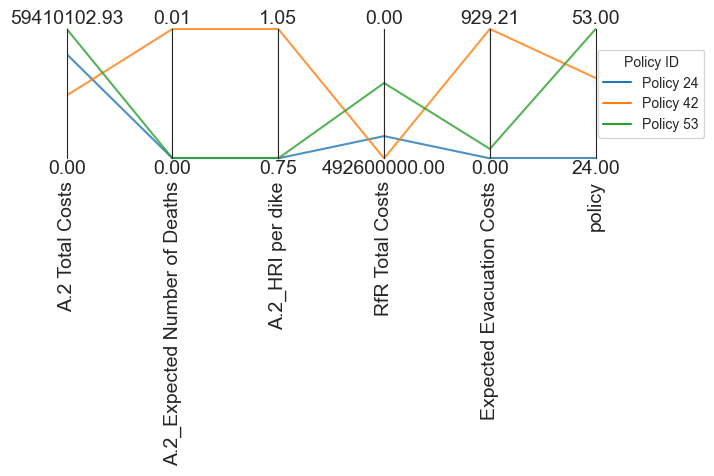

In [69]:
results_1 = results[logical]
results_1["policy"] = results_1.index  # Automatically uses 16, 17, 18 in your case


data = results_1.loc[:, [o.name for o in model.outcomes] + ['policy']]


limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths',
               'RfR Total Costs', 'Expected Evacuation Costs']] = 0


policy_ids = data["policy"].unique()
colors = sns.color_palette("tab10", len(policy_ids))
color_map = dict(zip(policy_ids, colors))


plt.figure(figsize=(14, 10))
paraxes = parcoords.ParallelAxes(limits)

# Plot each policy row with its assigned color
for _, row in data.iterrows():
    policy_id = row["policy"]
    color = color_map.get(policy_id, "gray")
    paraxes.plot(row.to_frame().T, color=color, alpha=0.8)

# Invert axis if needed
paraxes.invert_axis("RfR Total Costs")

from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color=color_map[pid], label=f"Policy {pid}")
    for pid in policy_ids
]
plt.legend(handles=legend_handles, title="Policy ID", loc="center left",bbox_to_anchor=(1.02, 0.5),borderaxespad=0)


plt.savefig("parallel_coords_MORDM_selected_policies.png", dpi=300, bbox_inches='tight')
plt.show()

## optimized policies

In [71]:
policies = results[logical]
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
24,0,0,0,0,0,0,1,0,0,0,...,0,5,5,4,5,7,3,9,5,5
42,1,0,0,0,0,0,0,0,1,0,...,0,5,3,4,7,7,0,9,6,8
53,1,0,0,0,0,0,0,0,0,0,...,0,3,5,1,2,6,2,6,3,6


In [72]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [73]:
#Create policy dataframe
lever_names = [l.name for l in model.levers]
#policies_df = results[lever_names]
policies.to_csv("candidate_policies.csv", index=False)

## Testing out the policies

In [75]:
n_scenarios = 20
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers

100%|██████████████████████████████████████████| 60/60 [00:07<00:00,  8.17it/s]
[MainProcess/INFO] terminating pool


In [76]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std


In [77]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
24,1.021756e+16,0.000526,1.680336,408000000.0,5.509107e+06
42,3.201649e+16,0.003266,1.100000,492600000.0,3.094217e+07
53,3.382566e+15,0.000080,3.211820,205800000.0,6.999354e+06


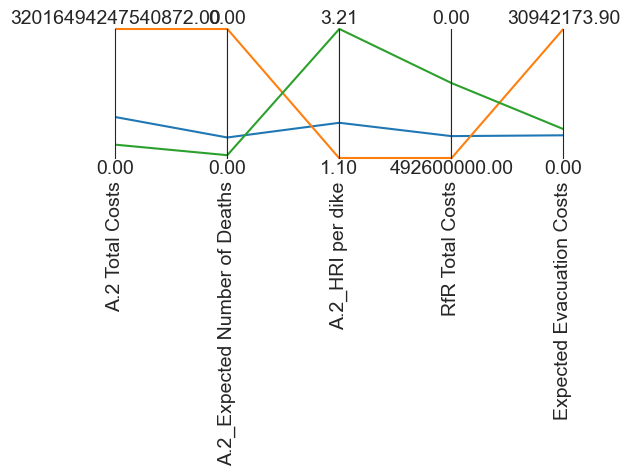

<Figure size 1400x1000 with 0 Axes>

In [78]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths', 'RfR Total Costs',"Expected Evacuation Costs"]] = 0


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
plt.figure(figsize=(14, 10))
plt.savefig("scores_single_MORDM.png", dpi=300, bbox_inches='tight') # width=12 inches, height=8 inches
plt.show()

In [79]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [80]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

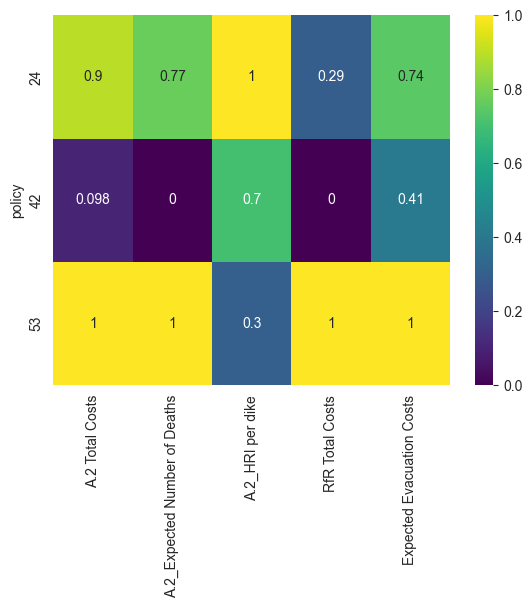

In [81]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.savefig("regret_single_MORDM.png", dpi=300, bbox_inches='tight')
plt.show()

In [82]:

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

  0%|                                                | 0/15000 [06:38<?, ?it/s]


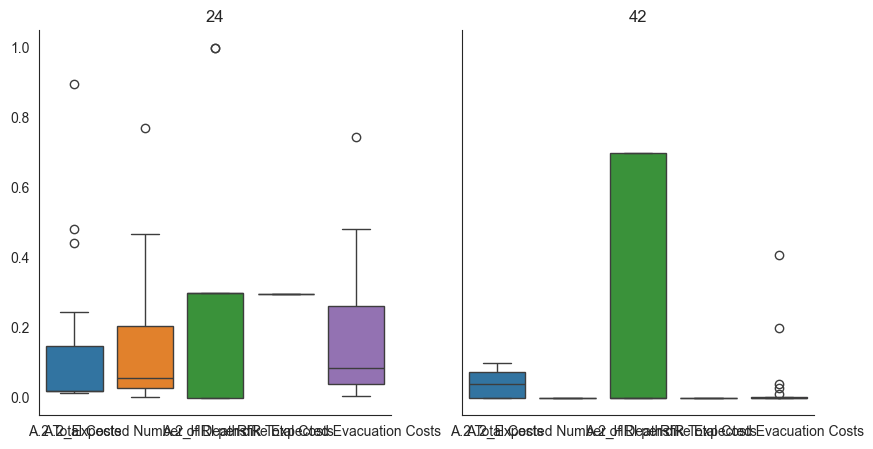

In [83]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(ncols=2, figsize=(10,5),
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this.


# zip allows us to zip together the list of axes and the list of
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    # removes top and left hand black outline of axes
    sns.despine()

    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()

## Selecteren scenarios maar gaan we doen met PRIM

In [84]:
policies_df = pd.read_csv("candidate_policies.csv")

# zet elke rij om in een Policy-object
candidate_policies = [
    Policy(f"cand_{i}", **row.to_dict())
    for i, row in policies_df.iterrows()

    ]

In [85]:
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(3)
    scenarios=10
    #policies=4
    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=scenarios, policies=candidate_policies )

        experiments, outcomes = results

[MainProcess/INFO] pool started with 7 workers
100%|██████████████████████████████████████████| 30/30 [00:03<00:00,  9.03it/s]
[MainProcess/INFO] terminating pool


In [86]:
hri_sys = outcomes["A.2_HRI per dike"]
hri_q25 = np.percentile(hri_sys, 25)# (N,) systeembreed
target_hri = hri_sys <= hri_q25

        # ---- 2.2 Expected Annual Damage ----
ead_total = outcomes["A.2 Total Costs"] # (N,)
ead_q75 = np.percentile(ead_total, 75)
target_ead = ead_total >= ead_q75

        # # ---- 2.3 RfR Total Costs ----
        # rfr_costs = outcomes["RfR Total Costs"].sum(axis=1)  # (N,)
        # rfr_q75 = np.percentile(rfr_costs, 75)
        # target_rfr = rfr_costs >= rfr_q75

        # ---- 2.4 Combineer tot één worst-case target ----
y = target_hri | target_ead        # booleaanse vector (N,)


# hri_baseline=baseline_outcomes["A.2_HRI per dike"]
# hri_sys = outcomes["A.2_HRI per dike"]
# hri_q25 = np.percentile(hri_baseline, 25)# (N,) systeembreed
# target_hri = hri_sys <= hri_q25
#
#         # ---- 2.2 Expected Annual Damage ----
# cost_baseline=baseline_outcomes["A.2 Total Costs"]
# cost_total = outcomes["A.2 Total Costs"] # (N,)
# cost_q75 = np.percentile(cost_baseline, 75)
# target_cost = cost_total >= cost_q75

        # # ---- 2.3 RfR Total Costs ----
        # rfr_costs = outcomes["RfR Total Costs"].sum(axis=1)  # (N,)
        # rfr_q75 = np.percentile(rfr_costs, 75)
        # target_rfr = rfr_costs >= rfr_q75

#         # ---- 2.4 Combineer tot één worst-case target ----
# y = target_hri | target_cost
# y

print(f"worst-cases: {y.sum()} van {n_scenarios*policies} runs  ({y.mean()*100:.1f} %)")

        # Determine model uncertainties
cols_unc = [u.name for u in model.uncertainties]
X = experiments[cols_unc]

#Start PRIM
prim_alg = prim.Prim(
            X, y,
            threshold=0.80,
        )

print("Aantal opgeslagen boxen:", len(prim_alg.boxes))

worst-cases: 12 van     0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
24        0        0        0        0        0        0       20        0   
42       20        0        0        0        0        0        0        0   
53       20        0        0        0        0        0        0        0   

    2_RfR 2  3_RfR 0  ...  A.2_DikeIncrease 2  A.3_DikeIncrease 0  \
24        0        0  ...                   0                 100   
42       20        0  ...                   0                 100   
53        0        0  ...                   0                  60   

    A.3_DikeIncrease 1  A.3_DikeIncrease 2  A.4_DikeIncrease 0  \
24                 100                  80                 100   
42                  60                  80                 140   
53                 100                  20                  40   

    A.4_DikeIncrease 1  A.4_DikeIncrease 2  A.5_DikeIncrease 0  \
24                 140                  60                 

[MainProcess/INFO] 30 points remaining, containing 12 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.2, coverage: 0.5, density: 1.0 restricted_dimensions: 4


coverage    0.5
density     1.0
id          5.0
k           6.0
mass        0.2
mean        1.0
n           6.0
res_dim     4.0
Name: 5, dtype: float64

                           box 5                                     
                             min              max  qp value  qp value
A.1_Bmax               34.766357       317.476255       NaN  0.087791
discount rate 1       {1.5, 3.5}       {1.5, 3.5}  0.087791       NaN
discount rate 2  {1.5, 3.5, 4.5}  {1.5, 3.5, 4.5}  1.000000       NaN
A.2_Bmax              159.023933       329.287778  1.000000       NaN



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{1.5, 3.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{1.5, 3.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


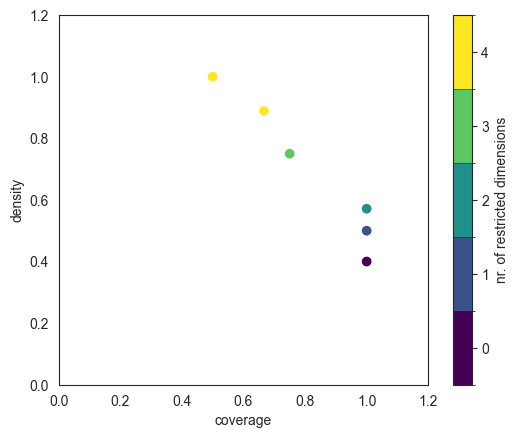

6 stappen in deze box


In [87]:
# A) De “beste” box volgens je threshold
box = prim_alg.find_box()
box.inspect()
box.show_tradeoff()
plt.show()# geeft een PrimBox terug
traj = box.peeling_trajectory
print(len(traj), "stappen in deze box")

[<Figure size 640x480 with 1 Axes>]

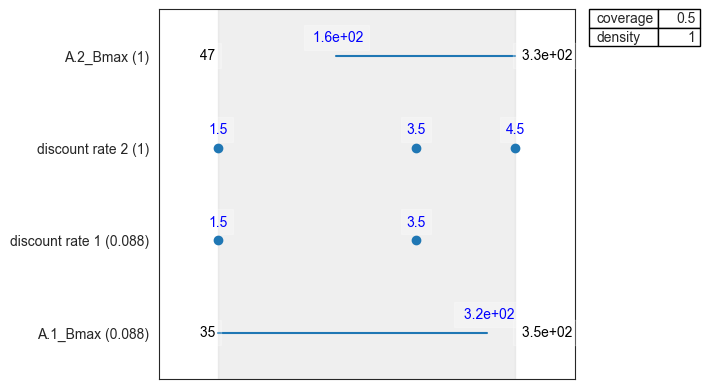

In [88]:
# en inspecteer 'm meteen
box.inspect( style="graph" )

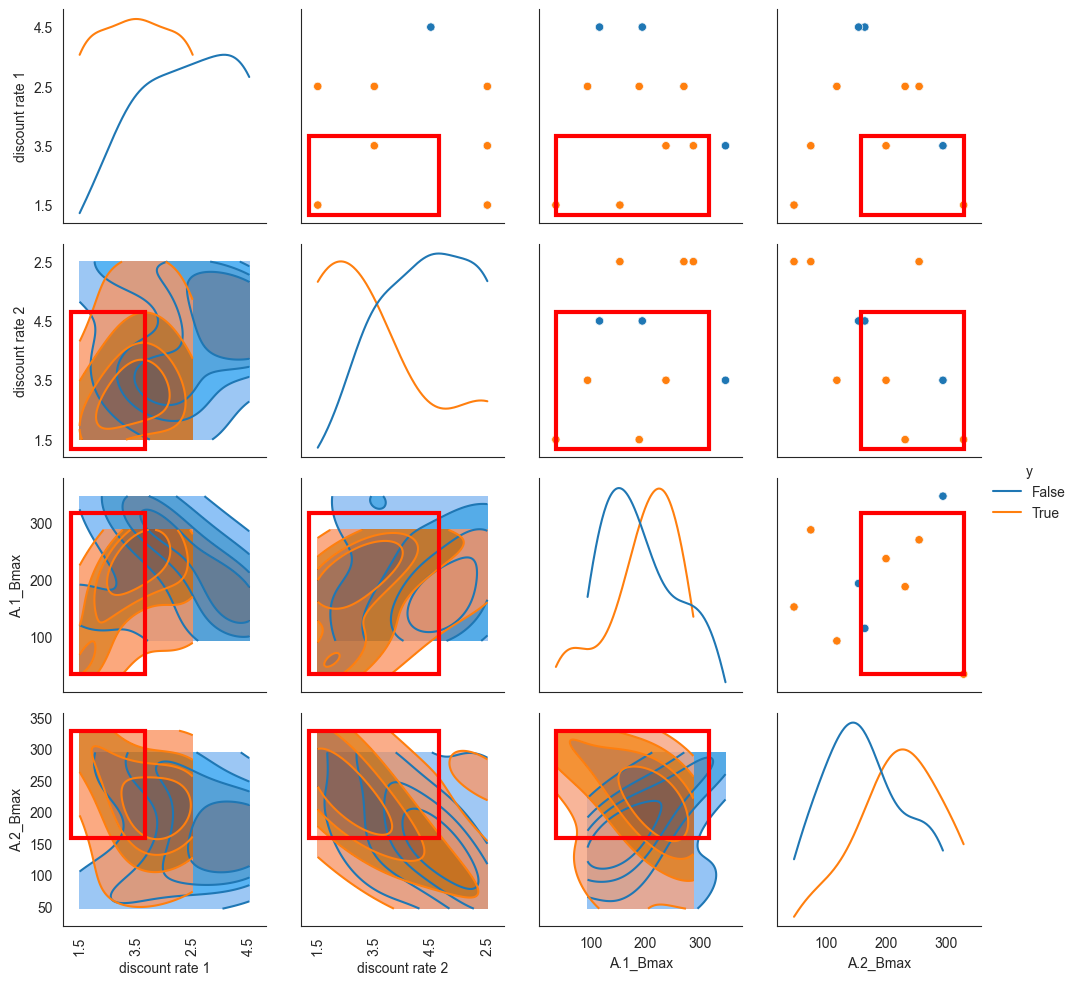

In [89]:
fig = box.show_pairs_scatter()
plt.show()

[MainProcess/INFO] model dropped from analysis because only a single category


origineel aantal kolommen: 53
zonder levers           : 22


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/dimensional_stacking.py:408: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pvt = pd.pivot_table(x_y_concat, values=ooi_label, index=rows, columns=columns, dropna=False)


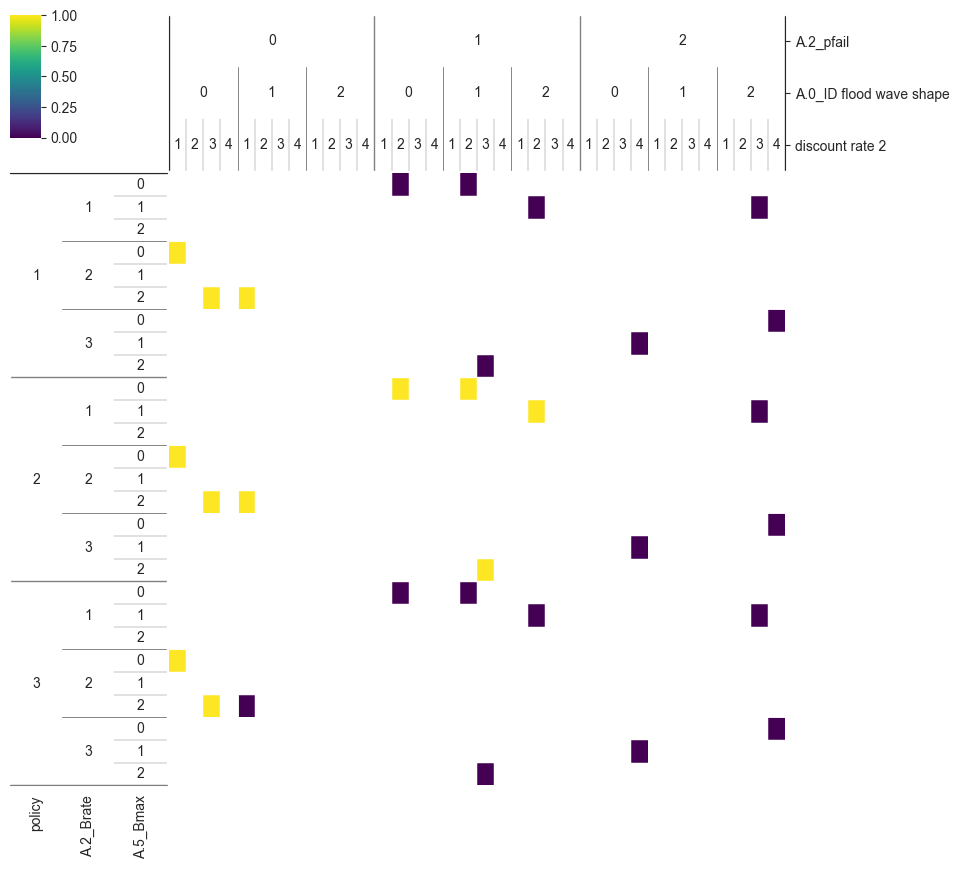

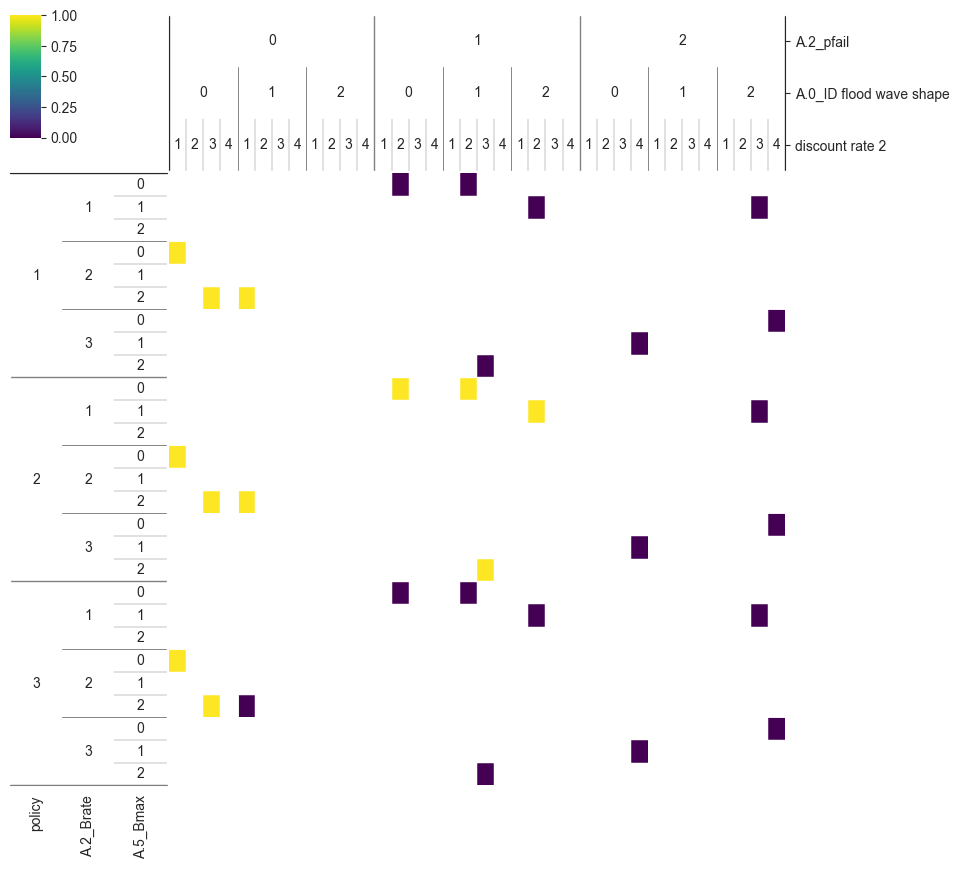

In [90]:
lever_names = [lev.name for lev in model.levers]
experiments_unc = experiments.drop(columns=lever_names)


# even checken:
print("origineel aantal kolommen:", experiments.shape[1])
print("zonder levers           :", experiments_unc.shape[1])

dimensional_stacking.create_pivot_plot(experiments_unc, y)


In [91]:

# 1) Haal de grenzen op uit de box (list met één entry per box in je peeling_trajectory)
raw_limits = box.box_lims[0]

# 1) Transponeren, zodat elke var een rij wordt, en de kolommen 0 en 1 zijn
df_lim = raw_limits.T

# 2) Hernoemen van de kolommen 0→min en 1→max
df_lim = df_lim.rename(columns={0: "min", 1: "max"})

# 3) (optioneel) zet de index-naam netjes
df_lim.index.name = "var"

In [92]:
df_lim
mask = pd.Series(True, index=experiments.index)

for var, row in df_lim.iterrows():
    lo, hi = row["min"], row["max"]
    ser = experiments[var]

    if is_numeric_dtype(ser):
        # voor numerieke parameters
        mask &= ser.between(lo, hi)
    else:
        # voor categorische parameters
        # lo kan een set/list zijn, of een enkele waarde
        if isinstance(lo, (set, list)):
            mask &= ser.isin(lo)
        else:
            mask &= (ser == lo)

exp_in_box = experiments[mask]
out_in_box = {
    name: array[mask.values]  # .values is een numpy‐boolean array
    for name, array in outcomes.items()
}

In [93]:
expanded = {}
for name, arr in out_in_box.items():
    if arr.ndim == 1:
        # gewoon een vector
        expanded[name] = arr
    else:
        # maak per tijdstap een kolom
        T = arr.shape[1]
        for t in range(T):
            expanded[f"{name}_{t}"] = arr[:, t]

out_df = pd.DataFrame(expanded)

In [94]:
exp_in_box['worst_case']=y[exp_in_box.index]
true_worst= exp_in_box[exp_in_box['worst_case']]
#
# true_worst = true_worst.assign(
#     total_cost = out_in_box['A.2 Total Costs']
# )

In [95]:
# --- 1) Maak één Series van alle total costs, met de originele index ---
all_costs = pd.Series(
    out_in_box['A.2 Total Costs'],       # numpy array voor _alle_ runs in out_in_box
    index = exp_in_box.index              # die hoort dezelfde lengte en index labels te hebben
)

# --- 2) Filter die Series naar alleen de worst‐case subset (true_worst.index) ---
worst_costs = all_costs.loc[true_worst.index]

# --- 3) Wijs die gefilterde Series toe als nieuwe kolom ---
true_worst = true_worst.assign(total_costs=worst_costs)

In [96]:
true_worst['total_costs'] = pd.Series(
    out_in_box['A.2 Total Costs'],
    index=exp_in_box.index
).loc[true_worst.index]

In [97]:
true_worst

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,worst_case,total_costs
5,79,188.189436,1.0,0.377464,231.821807,1.5,0.221926,116.506386,1.0,0.829152,...,7,3,9,5,5,3025,cand_0,dikesnet,True,6.407927e+07
7,36,237.439820,1.5,0.630914,199.999421,1.5,0.088606,325.584151,10.0,0.435362,...,7,3,9,5,5,3027,cand_0,dikesnet,True,1.039571e+08
9,6,34.766357,1.0,0.802037,329.287778,1.5,0.164332,275.444837,1.0,0.579336,...,7,3,9,5,5,3029,cand_0,dikesnet,True,9.915107e+07
10,85,93.080915,1.5,0.474064,118.048446,10.0,0.521261,47.846873,1.5,0.793195,...,7,0,9,6,8,3020,cand_1,dikesnet,True,3.222458e+07
12,128,287.905513,10.0,0.598561,74.575080,1.0,0.633413,310.729903,1.0,0.113425,...,7,0,9,6,8,3022,cand_1,dikesnet,True,3.703747e+07
14,44,270.447947,10.0,0.068644,255.132767,1.0,0.387738,179.600171,1.5,0.214632,...,7,0,9,6,8,3024,cand_1,dikesnet,True,4.737923e+07
15,79,188.189436,1.0,0.377464,231.821807,1.5,0.221926,116.506386,1.0,0.829152,...,7,0,9,6,8,3025,cand_1,dikesnet,True,1.913598e+08
17,36,237.439820,1.5,0.630914,199.999421,1.5,0.088606,325.584151,10.0,0.435362,...,7,0,9,6,8,3027,cand_1,dikesnet,True,3.734945e+08
18,62,152.626405,1.0,0.920071,46.624341,1.0,0.495092,76.523420,1.5,0.071290,...,7,0,9,6,8,3028,cand_1,dikesnet,True,3.921913e+07
19,6,34.766357,1.0,0.802037,329.287778,1.5,0.164332,275.444837,1.0,0.579336,...,7,0,9,6,8,3029,cand_1,dikesnet,True,3.565480e+08


In [98]:
# --- 1) Maak één Series van alle total costs, met de originele index ---
all_costs = pd.Series(
    out_in_box['A.2_HRI per dike'],       # numpy array voor _alle_ runs in out_in_box
    index = exp_in_box.index              # die hoort dezelfde lengte en index labels te hebben
)

# --- 2) Filter die Series naar alleen de worst‐case subset (true_worst.index) ---
worst_HRI = all_costs.loc[true_worst.index]

# --- 3) Wijs die gefilterde Series toe als nieuwe kolom ---
true_worst = true_worst.assign(HRI=worst_HRI)

In [99]:
true_worst

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,worst_case,total_costs,HRI
5,79,188.189436,1.0,0.377464,231.821807,1.5,0.221926,116.506386,1.0,0.829152,...,3,9,5,5,3025,cand_0,dikesnet,True,6.407927e+07,0.75
7,36,237.439820,1.5,0.630914,199.999421,1.5,0.088606,325.584151,10.0,0.435362,...,3,9,5,5,3027,cand_0,dikesnet,True,1.039571e+08,-0.25
9,6,34.766357,1.0,0.802037,329.287778,1.5,0.164332,275.444837,1.0,0.579336,...,3,9,5,5,3029,cand_0,dikesnet,True,9.915107e+07,-0.25
10,85,93.080915,1.5,0.474064,118.048446,10.0,0.521261,47.846873,1.5,0.793195,...,0,9,6,8,3020,cand_1,dikesnet,True,3.222458e+07,0.05
12,128,287.905513,10.0,0.598561,74.575080,1.0,0.633413,310.729903,1.0,0.113425,...,0,9,6,8,3022,cand_1,dikesnet,True,3.703747e+07,0.05
14,44,270.447947,10.0,0.068644,255.132767,1.0,0.387738,179.600171,1.5,0.214632,...,0,9,6,8,3024,cand_1,dikesnet,True,4.737923e+07,0.05
15,79,188.189436,1.0,0.377464,231.821807,1.5,0.221926,116.506386,1.0,0.829152,...,0,9,6,8,3025,cand_1,dikesnet,True,1.913598e+08,0.05
17,36,237.439820,1.5,0.630914,199.999421,1.5,0.088606,325.584151,10.0,0.435362,...,0,9,6,8,3027,cand_1,dikesnet,True,3.734945e+08,0.05
18,62,152.626405,1.0,0.920071,46.624341,1.0,0.495092,76.523420,1.5,0.071290,...,0,9,6,8,3028,cand_1,dikesnet,True,3.921913e+07,0.05
19,6,34.766357,1.0,0.802037,329.287778,1.5,0.164332,275.444837,1.0,0.579336,...,0,9,6,8,3029,cand_1,dikesnet,True,3.565480e+08,0.05


In [100]:
# 1) min-max schaal HRI en costs
hri = true_worst['HRI']
cost = true_worst['total_costs']

hri_scaled = (hri - hri.min()) / (hri.max() - hri.min())
cost_scaled = (cost - cost.min()) / (cost.max() - cost.min())

# 2) keer de costs om
inv_cost = 1 - cost_scaled

# 3) bereken de samengestelde score
score = hri_scaled * inv_cost

# 4) voeg toe aan true_worst
true_worst = true_worst.assign(
    hri_scaled = hri_scaled,
    cost_scaled = cost_scaled,
    inv_cost    = inv_cost,
    score       = score
)

true_worst.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,scenario,policy,model,worst_case,total_costs,HRI,hri_scaled,cost_scaled,inv_cost,score
5,79,188.189436,1.0,0.377464,231.821807,1.5,0.221926,116.506386,1.0,0.829152,...,3025,cand_0,dikesnet,True,6.407927e+07,0.75,1.0,0.093342,0.906658,0.906658
7,36,237.439820,1.5,0.630914,199.999421,1.5,0.088606,325.584151,10.0,0.435362,...,3027,cand_0,dikesnet,True,1.039571e+08,-0.25,0.0,0.210193,0.789807,0.000000
9,6,34.766357,1.0,0.802037,329.287778,1.5,0.164332,275.444837,1.0,0.579336,...,3029,cand_0,dikesnet,True,9.915107e+07,-0.25,0.0,0.196110,0.803890,0.000000
10,85,93.080915,1.5,0.474064,118.048446,10.0,0.521261,47.846873,1.5,0.793195,...,3020,cand_1,dikesnet,True,3.222458e+07,0.05,0.3,0.000000,1.000000,0.300000
12,128,287.905513,10.0,0.598561,74.575080,1.0,0.633413,310.729903,1.0,0.113425,...,3022,cand_1,dikesnet,True,3.703747e+07,0.05,0.3,0.014103,0.985897,0.295769


In [101]:
# # 1) voeg y als kolom toe
# exp_in_box = exp_in_box.copy()
# exp_in_box['worst_case'] = y[exp_in_box.index]
#
# # 2) houd alleen echte worst-cases over
# true_worst = exp_in_box[exp_in_box['worst_case']]

# 3) kies uit true_worst je max/min/median voor EAD & HRI
best  = true_worst.nlargest(1, 'score')   #best case is hoogste
worst = true_worst.nsmallest(1,  'score')      #worst case is laagste
mid   = true_worst.iloc[[len(true_worst)//2]]

In [102]:
# 1) knijp de rij samen naar een Series
best_s   = best.iloc[0]  # of .iloc[0]
mid_s = mid.iloc[0]
worst_s  = worst.iloc[0]



df_scenarios = pd.DataFrame([
    best_s.to_dict(),
    mid_s.to_dict(),
    worst_s.to_dict()
], index=["best_case", "median_case", "worst_case"])

df_scenarios = (
    df_scenarios
    .rename(columns={"scenario.1": "scenario"})  # als hij zo heet
    .set_index("scenario")                        # zet de kolom als index
)

In [103]:
df_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 2,policy,model,worst_case,total_costs,HRI,hri_scaled,cost_scaled,inv_cost,score
scenario,,,,,,,,,,,,,,,,,,,,,
3025,79,188.189436,1.0,0.377464,231.821807,1.5,0.221926,116.506386,1.0,0.829152,...,5,cand_0,dikesnet,True,6.407927e+07,0.75,1.0,0.093342,0.906658,0.906658
3025,79,188.189436,1.0,0.377464,231.821807,1.5,0.221926,116.506386,1.0,0.829152,...,8,cand_1,dikesnet,True,1.913598e+08,0.05,0.3,0.466303,0.533697,0.160109
3027,36,237.439820,1.5,0.630914,199.999421,1.5,0.088606,325.584151,10.0,0.435362,...,5,cand_0,dikesnet,True,1.039571e+08,-0.25,0.0,0.210193,0.789807,0.000000


In [104]:
df_scenarios.to_csv("reference_scenarios.csv", index_label="scenario")


In [105]:
candidate_scenarios = [
    Scenario(f"scenario_{idx}", **row.to_dict())
    for idx, row in df_scenarios.iterrows()
]

In [106]:
for scenario in candidate_scenarios:
    print(scenario)

Scenario({'A.0_ID flood wave shape': 79, 'A.1_Bmax': 188.18943622009354, 'A.1_Brate': 1.0, 'A.1_pfail': 0.3774637220303475, 'A.2_Bmax': 231.8218073066467, 'A.2_Brate': 1.5, 'A.2_pfail': 0.2219259794745367, 'A.3_Bmax': 116.50638552156806, 'A.3_Brate': 1.0, 'A.3_pfail': 0.8291523677635236, 'A.4_Bmax': 77.8506026458694, 'A.4_Brate': 10.0, 'A.4_pfail': 0.9777354832951728, 'A.5_Bmax': 263.6579246864197, 'A.5_Brate': 1.0, 'A.5_pfail': 0.2132959858031429, 'discount rate 0': 1.5, 'discount rate 1': 2.5, 'discount rate 2': 1.5, '0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 1, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 1, '4_RfR 2': 0, 'EWS_DaysToThreat': 1, 'A.1_DikeIncrease 0': 5, 'A.1_DikeIncrease 1': 6, 'A.1_DikeIncrease 2': 2, 'A.2_DikeIncrease 0': 3, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 5, 'A.3_DikeIncrease 1': 5, 'A.3_DikeIncrease 2': 4, 'A.4_DikeIncrease

## scenario's uit PRIM

In [107]:
# df_scenarios= pd.read_csv('reference_scenarios.csv')
#
# df_scenarios = (
#     df_scenarios
#     .rename(columns={"scenario.1": "scenario"})
#     .set_index("scenario")            )

In [108]:
# df_scenarios=df_scenarios[cols_unc]
# df_scenarios

In [109]:
    # candidate_scenarios = [
    #     Scenario(f"scenario_{idx}", **row.to_dict())
    #     for idx, row in df_scenarios.iterrows()
    # ]

## vanaf hier wordt het multi MORDM

In [110]:

ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

In [111]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.em_framework.optimization import to_problem
import pandas as pd

ema_logging.log_to_stderr(ema_logging.INFO)


nfe = 150
epsilons = [0.01] * len(model.outcomes)

results = []
convergence_records = []

with MultiprocessingEvaluator(model) as evaluator:
    for i, scenario in enumerate(candidate_scenarios[:3]):
        #for seed in range(3):
        print(f"🔄 Running: Scenario {i} ({scenario.name}) ")

        eps_prog = EpsilonProgress()
        result, convergence = evaluator.optimize(
                nfe=nfe,
                searchover="levers",
                epsilons=epsilons,
                convergence=[eps_prog],
                reference=scenario,constraints=[max_one_rfr_constraint]
            )

            # Store optimization results
        results.append(pd.DataFrame(result))

            # The convergence object is a DataFrame already
        convergence_df = pd.DataFrame(convergence)
        convergence_df["scenario"] = scenario.name
        #convergence_df["seed"] = seed
        convergence_records.append(convergence_df)

# Merge final dataframes
combined_results = pd.concat(results, ignore_index=True)
convergence_df = pd.concat(convergence_records, ignore_index=True)

[MainProcess/INFO] pool started with 8 workers


🔄 Running: Scenario 0 (scenario_3025) 


 67%|██████████████████████████▋             | 100/150 [00:11<00:05,  8.80it/s]INFO | EpsNSGAII finished; Total NFE: 200, Elapsed Time: 0:00:23.890348
200it [00:23,  8.37it/s]                                                       
[MainProcess/INFO] optimization completed, found 3 solutions


🔄 Running: Scenario 1 (scenario_3025) 


 67%|██████████████████████████▋             | 100/150 [00:12<00:06,  8.04it/s]INFO | EpsNSGAII finished; Total NFE: 200, Elapsed Time: 0:00:24.828353
200it [00:24,  8.05it/s]                                                       
[MainProcess/INFO] optimization completed, found 8 solutions


🔄 Running: Scenario 2 (scenario_3027) 


 67%|██████████████████████████▋             | 100/150 [00:11<00:05,  8.36it/s]INFO | EpsNSGAII finished; Total NFE: 200, Elapsed Time: 0:00:23.805620
200it [00:23,  8.40it/s]                                                       
[MainProcess/INFO] optimization completed, found 10 solutions
[MainProcess/INFO] terminating pool


KeyError: 'seed'

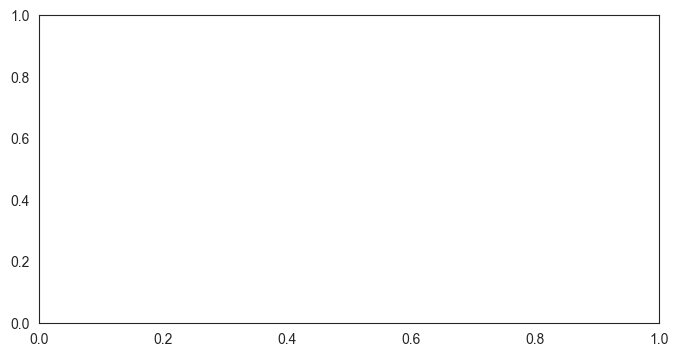

In [112]:
# === PLOT ε-PROGRESS BY SCENARIO ===
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(8, 4))
colors = sns.color_palette()
legend_items = []

for (scenario_name, scores), color in zip(convergence_df.groupby("scenario"), colors):
    # Create custom legend item
    legend_items.append((mpl.lines.Line2D([0, 0], [1, 1], c=color), scenario_name))

    # Plot each seed
    for seed, score in scores.groupby("seed"):
        ax.plot(score.nfe, score.epsilon_progress, c=color, lw=1)

ax.set_ylabel(r'$\epsilon$ progress')
ax.set_xlabel('number of function evaluations')

# Add legend
artists, labels = zip(*legend_items)
fig.legend(artists, labels, bbox_to_anchor=(1.02, 0.9))

plt.tight_layout()
plt.savefig("convergence_multi_mordm.png", dpi=300, bbox_inches='tight')
plt.show()

In [113]:
combined_results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,1,0,0,0,0,0,1,0,0,0,...,10,3,10,2,7,1.861676e+08,0.000266,0.69,492600000.0,143.011421
1,0,1,0,1,0,0,0,1,0,0,...,5,1,8,5,10,1.530678e+08,0.000971,1.02,710400000.0,289.683783
2,0,0,1,0,0,0,1,0,0,0,...,0,3,4,3,7,2.922704e+08,0.000000,0.62,371400000.0,817.011441
3,0,0,0,1,0,0,0,1,0,0,...,3,5,4,5,3,2.436361e+08,0.000000,0.98,504600000.0,1203.918617
4,0,0,1,0,0,0,0,1,0,0,...,6,7,8,8,0,2.086897e+08,0.000000,0.62,236500000.0,91.400047
5,0,0,0,0,1,0,0,0,1,0,...,0,8,6,9,1,1.160050e+08,0.000000,1.05,625800000.0,0.000000
6,0,1,0,0,0,0,0,0,0,1,...,3,3,6,0,9,2.689574e+08,0.000000,0.66,461900000.0,0.000000
7,0,0,0,1,0,0,0,0,1,0,...,8,2,5,7,3,1.835519e+08,0.003281,0.68,248500000.0,1893.173044
8,0,0,0,1,0,0,0,0,0,0,...,2,6,5,2,2,1.940428e+08,0.000104,0.69,473900000.0,331.592310
9,0,1,0,0,1,0,1,0,0,0,...,0,4,2,5,1,2.343025e+08,0.000000,0.99,454300000.0,1450.398552


In [114]:
print(combined_results)

    0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0         1        0        0        0        0        0        1        0   
1         0        1        0        1        0        0        0        1   
2         0        0        1        0        0        0        1        0   
3         0        0        0        1        0        0        0        1   
4         0        0        1        0        0        0        0        1   
5         0        0        0        0        1        0        0        0   
6         0        1        0        0        0        0        0        0   
7         0        0        0        1        0        0        0        0   
8         0        0        0        1        0        0        0        0   
9         0        1        0        0        1        0        1        0   
10        0        0        0        0        0        1        0        0   
11        0        0        0        1        0        0        

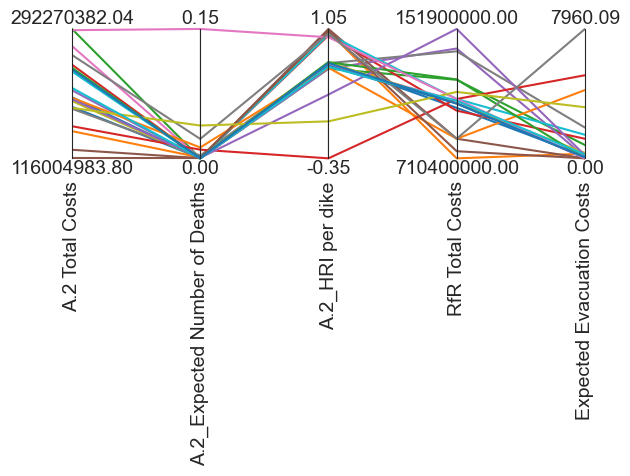

<Figure size 1400x1000 with 0 Axes>

In [115]:
data = combined_results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
    # Set larger figure size (wider and taller)
plt.figure(figsize=(14, 10))
plt.savefig("multi mordm all.png", dpi=300, bbox_inches='tight') # width=12 inches, height=8 inches


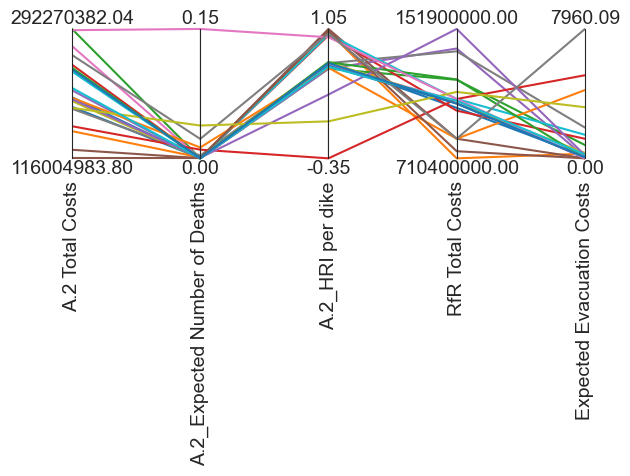

In [116]:

# Generate parallel axes with your limits
paraxes = parcoords.ParallelAxes(limits)

# Plot the data
paraxes.plot(data)

# Invert specific axis
paraxes.invert_axis("RfR Total Costs")

# Save the plot
plt.savefig("mordm_parallel_coordinates.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [126]:



logical = (
    (combined_results["A.2 Total Costs"] < 4e8) &

    (combined_results["A.2_HRI per dike"] > 0.7))



np.sum(logical)
combined_results[logical]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
1,0,1,0,1,0,0,0,1,0,0,...,5,1,8,5,10,1.530678e+08,0.000971,1.02,710400000.0,289.683783
3,0,0,0,1,0,0,0,1,0,0,...,3,5,4,5,3,2.436361e+08,0.000000,0.98,504600000.0,1203.918617
5,0,0,0,0,1,0,0,0,1,0,...,0,8,6,9,1,1.160050e+08,0.000000,1.05,625800000.0,0.000000
9,0,1,0,0,1,0,1,0,0,0,...,0,4,2,5,1,2.343025e+08,0.000000,0.99,454300000.0,1450.398552
15,0,1,0,1,0,0,0,0,0,0,...,6,8,6,7,6,1.276696e+08,0.000221,1.03,679700000.0,0.000000
16,1,0,0,0,1,0,1,0,0,0,...,5,6,6,2,10,2.905818e+08,0.151872,0.96,454300000.0,0.000000
17,0,0,0,0,1,0,0,1,0,0,...,10,1,1,2,5,2.567565e+08,0.022781,1.00,625800000.0,7960.092727


/var/folders/sp/3r57ckwj0f59wpwykds8r5040000gn/T/ipykernel_28432/2740734344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_2["policy"] = results_2.index  # Automatically uses 16, 17, 18 in your case


<Figure size 1400x1000 with 0 Axes>

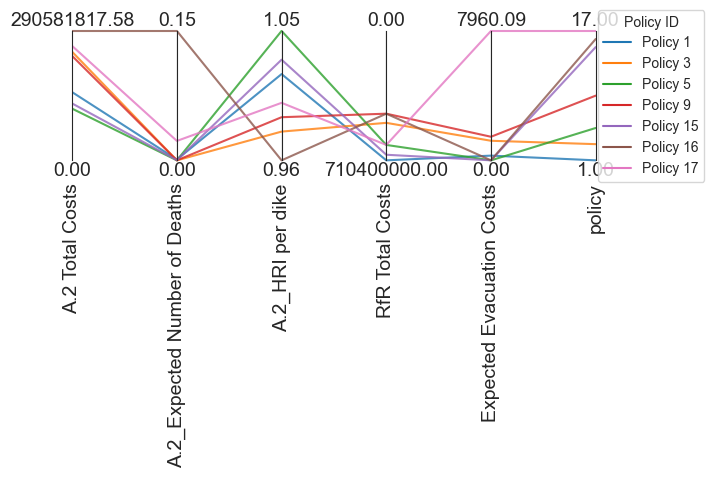

In [123]:

results_2 = combined_results[logical]
results_2["policy"] = results_2.index  # Automatically uses 16, 17, 18 in your case


data = results_2.loc[:, [o.name for o in model.outcomes] + ['policy']]


limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths',
               'RfR Total Costs', 'Expected Evacuation Costs']] = 0


policy_ids = data["policy"].unique()
colors = sns.color_palette("tab10", len(policy_ids))
color_map = dict(zip(policy_ids, colors))


plt.figure(figsize=(14, 10))
paraxes = parcoords.ParallelAxes(limits)

# Plot each policy row with its assigned color
for _, row in data.iterrows():
    policy_id = row["policy"]
    color = color_map.get(policy_id, "gray")
    paraxes.plot(row.to_frame().T, color=color, alpha=0.8)

# Invert axis if needed
paraxes.invert_axis("RfR Total Costs")


legend_handles = [
    Line2D([0], [0], color=color_map[pid], label=f"Policy {pid}")
    for pid in policy_ids
]
plt.legend(handles=legend_handles, title="Policy ID", loc="center left",bbox_to_anchor=(1.02, 0.5),borderaxespad=0)


plt.savefig("parallel_coords_multi_MORDM_selected_policies.png", dpi=300, bbox_inches='tight')
plt.show()

In [127]:
policies = combined_results[logical]
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
1,0,1,0,1,0,0,0,1,0,0,...,3,1,10,5,7,5,1,8,5,10
3,0,0,0,1,0,0,0,1,0,0,...,7,4,7,7,8,3,5,4,5,3
5,0,0,0,0,1,0,0,0,1,0,...,0,3,3,0,6,0,8,6,9,1
9,0,1,0,0,1,0,1,0,0,0,...,6,0,4,1,10,0,4,2,5,1
15,0,1,0,1,0,0,0,0,0,0,...,2,6,1,6,9,6,8,6,7,6
16,1,0,0,0,1,0,1,0,0,0,...,9,5,7,0,5,5,6,6,2,10
17,0,0,0,0,1,0,0,1,0,0,...,5,7,7,1,2,10,1,1,2,5


In [128]:
test=combined_results[logical]
test

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
1,0,1,0,1,0,0,0,1,0,0,...,5,1,8,5,10,1.530678e+08,0.000971,1.02,710400000.0,289.683783
3,0,0,0,1,0,0,0,1,0,0,...,3,5,4,5,3,2.436361e+08,0.000000,0.98,504600000.0,1203.918617
5,0,0,0,0,1,0,0,0,1,0,...,0,8,6,9,1,1.160050e+08,0.000000,1.05,625800000.0,0.000000
9,0,1,0,0,1,0,1,0,0,0,...,0,4,2,5,1,2.343025e+08,0.000000,0.99,454300000.0,1450.398552
15,0,1,0,1,0,0,0,0,0,0,...,6,8,6,7,6,1.276696e+08,0.000221,1.03,679700000.0,0.000000
16,1,0,0,0,1,0,1,0,0,0,...,5,6,6,2,10,2.905818e+08,0.151872,0.96,454300000.0,0.000000
17,0,0,0,0,1,0,0,1,0,0,...,10,1,1,2,5,2.567565e+08,0.022781,1.00,625800000.0,7960.092727


## Hier onder worden de policies gemaakt die getest moeten worden

In [129]:

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [131]:
n_scenarios = 10
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers
100%|██████████████████████████████████████████| 70/70 [00:08<00:00,  8.55it/s]
[MainProcess/INFO] terminating pool


In [132]:
results

(    A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
 0                        79  343.657710       1.0   0.938282  158.880077   
 1                       101  129.601343       1.5   0.202839  322.535925   
 2                       116  271.407087      10.0   0.837986   52.172495   
 3                        50   49.493780       1.5   0.317015  279.405042   
 4                        55  193.238573      10.0   0.596106  139.255027   
 ..                      ...         ...       ...        ...         ...   
 65                      125   85.776759      10.0   0.034622  238.178780   
 66                        9  222.983721       1.0   0.749259   77.246903   
 67                       34   96.933233      10.0   0.627239  102.885827   
 68                       90  182.240158       1.5   0.426568  198.799118   
 69                       16  317.233277       1.0   0.145243  309.523412   
 
    A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ...  \
 0      

In [133]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std


In [134]:
from ema_workbench import ScalarOutcome

experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
1,8.876214e+15,1.282413e-05,1.020000e+00,710400000.0,1.423382e+07
15,6.635461e+14,4.659757e-06,4.638708e+15,679700000.0,0.000000e+00
16,3.393930e+16,5.602601e-03,8.646911e+15,454300000.0,0.000000e+00
17,2.885196e+16,1.264690e-04,1.000000e+00,625800000.0,2.446625e+07
3,2.269161e+15,1.976309e-07,8.827055e+15,504600000.0,3.142528e+07
5,9.645606e+14,1.779493e-07,4.728780e+15,625800000.0,4.678443e+06
9,7.388300e+14,3.845838e-08,9.900000e-01,454300000.0,3.541019e+07


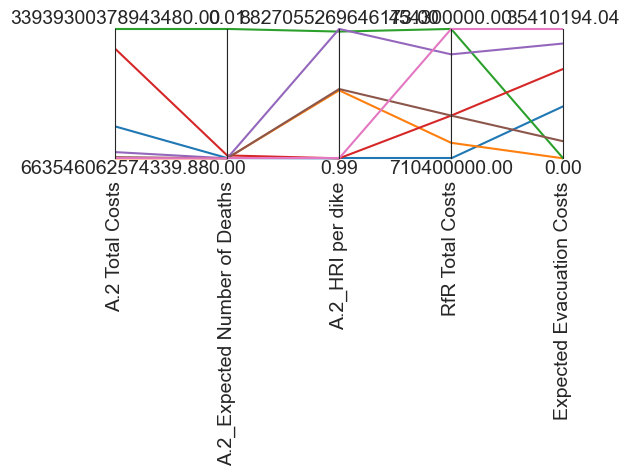

In [135]:
data = scores
limits = parcoords.get_limits(data)


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")

plt.show()

In [136]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

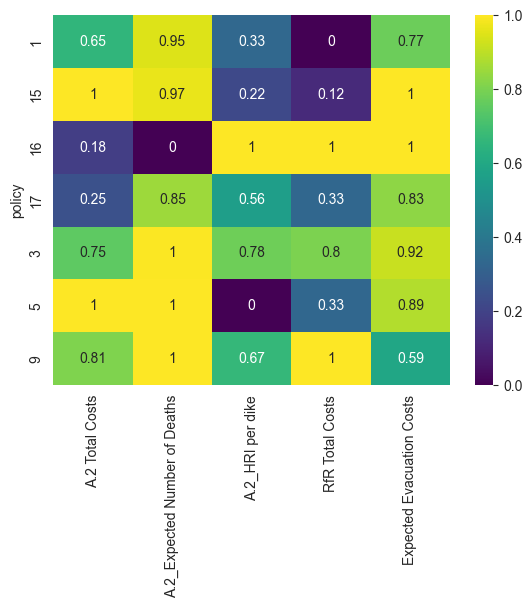

In [137]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.savefig("regret multi mordm.png", dpi=300, bbox_inches='tight')
plt.show()

In [138]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,79,343.657710,1.0,0.938282,158.880077,1.0,0.988773,66.783487,1.0,0.454182,...,5,7,5,1,8,5,10,3030,1,dikesnet
1,101,129.601343,1.5,0.202839,322.535925,1.0,0.208350,108.090782,1.5,0.667527,...,5,7,5,1,8,5,10,3031,1,dikesnet
2,116,271.407087,10.0,0.837986,52.172495,10.0,0.025820,316.737108,10.0,0.320408,...,5,7,5,1,8,5,10,3032,1,dikesnet
3,50,49.493780,1.5,0.317015,279.405042,10.0,0.166882,187.585053,10.0,0.057778,...,5,7,5,1,8,5,10,3033,1,dikesnet
4,55,193.238573,10.0,0.596106,139.255027,10.0,0.802356,36.189217,1.5,0.232832,...,5,7,5,1,8,5,10,3034,1,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,125,85.776759,10.0,0.034622,238.178780,1.5,0.348930,324.601259,1.0,0.181896,...,1,2,10,1,1,2,5,3035,17,dikesnet
66,9,222.983721,1.0,0.749259,77.246903,1.5,0.659890,263.281058,1.5,0.859353,...,1,2,10,1,1,2,5,3036,17,dikesnet
67,34,96.933233,10.0,0.627239,102.885827,1.0,0.522169,246.037672,10.0,0.544759,...,1,2,10,1,1,2,5,3037,17,dikesnet
68,90,182.240158,1.5,0.426568,198.799118,1.0,0.463015,201.408405,1.0,0.705489,...,1,2,10,1,1,2,5,3038,17,dikesnet


In [139]:
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
1,0,1,0,1,0,0,0,1,0,0,...,3,1,10,5,7,5,1,8,5,10
3,0,0,0,1,0,0,0,1,0,0,...,7,4,7,7,8,3,5,4,5,3
5,0,0,0,0,1,0,0,0,1,0,...,0,3,3,0,6,0,8,6,9,1
9,0,1,0,0,1,0,1,0,0,0,...,6,0,4,1,10,0,4,2,5,1
15,0,1,0,1,0,0,0,0,0,0,...,2,6,1,6,9,6,8,6,7,6
16,1,0,0,0,1,0,1,0,0,0,...,9,5,7,0,5,5,6,6,2,10
17,0,0,0,0,1,0,0,1,0,0,...,5,7,7,1,2,10,1,1,2,5


In [140]:
policies.to_csv("multi-scenario_policies.csv", index=True)


## PRIM analyse met multi scenario policies voor robustness

In [141]:
# lees de CSV in met de gevonden policies vanuit de MORDM
policies_multiscenario = pd.read_csv("multi-scenario_policies.csv")

# zet elke rij om in een Policy-object
multiscenario_policies = [
    Policy(f"cand_{i}", **row.to_dict())
    for i, row in policies_multiscenario.iterrows()

    ]


In [143]:
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(3)

    df_pols = pd.read_csv("multi-scenario_policies.csv")

    # policies = [
    #     Policy(f"policy_{i}", **row.to_dict())
    #     for i, row in df_pols.iterrows()
    # ]

    scenarios=10
    policies=multiscenario_policies #policies retrieved from multi scenario MORDM
    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=scenarios, policies=policies )

        experiments, outcomes = results

[MainProcess/INFO] pool started with 7 workers
100%|██████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]
[MainProcess/INFO] terminating pool


In [144]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,98,89.014900,10.0,0.786512,277.682293,10.0,0.604287,79.110852,1.0,0.015524,...,5,7,5,1,8,5,10,3040,cand_0,dikesnet
1,42,118.553976,1.0,0.883325,158.823091,1.5,0.511360,253.363231,10.0,0.958893,...,5,7,5,1,8,5,10,3041,cand_0,dikesnet
2,68,287.732755,10.0,0.055628,249.145182,1.5,0.749088,158.321670,1.5,0.740757,...,5,7,5,1,8,5,10,3042,cand_0,dikesnet
3,5,149.030745,1.5,0.679500,306.923412,10.0,0.375682,151.111487,10.0,0.600381,...,5,7,5,1,8,5,10,3043,cand_0,dikesnet
4,111,204.704916,1.5,0.261176,213.290223,1.5,0.941906,215.198299,1.5,0.521277,...,5,7,5,1,8,5,10,3044,cand_0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,35,36.004841,10.0,0.360914,332.939427,1.0,0.181572,56.709185,1.0,0.346034,...,1,2,10,1,1,2,5,3045,cand_6,dikesnet
66,86,189.148868,1.0,0.918794,44.372367,1.0,0.805419,285.560102,10.0,0.493775,...,1,2,10,1,1,2,5,3046,cand_6,dikesnet
67,61,329.645248,1.5,0.497186,148.842055,1.0,0.488537,115.958274,1.5,0.157070,...,1,2,10,1,1,2,5,3047,cand_6,dikesnet
68,17,257.284463,10.0,0.197408,85.241416,10.0,0.020787,291.879627,1.5,0.270961,...,1,2,10,1,1,2,5,3048,cand_6,dikesnet


In [145]:
results_per_policy = {}

hri_baseline=baseline_outcomes["A.2_HRI per dike"]
hri_sys = outcomes["A.2_HRI per dike"]
hri_q25 = np.percentile(hri_baseline, 25)# (N,) systeembreed
target_hri = hri_sys <= hri_q25

        # ---- 2.2 Expected Annual Damage ----
cost_baseline=baseline_outcomes["A.2 Total Costs"]
cost_total = outcomes["A.2 Total Costs"] # (N,)
cost_q75 = np.percentile(cost_baseline, 75)
target_cost = cost_total >= cost_q75

        # # ---- 2.3 RfR Total Costs ----
        # rfr_costs = outcomes["RfR Total Costs"].sum(axis=1)  # (N,)
        # rfr_q75 = np.percentile(rfr_costs, 75)
        # target_rfr = rfr_costs >= rfr_q75

        # ---- 2.4 Combineer tot één worst-case target ----
y = target_hri | target_cost
y


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False,  True, False, False,  True,  True])

In [146]:
for pol in multiscenario_policies:

    pol_name = pol.name

    # selecteer alleen de runs met exact die naam
    mask_pol = experiments["policy"] == pol_name
    X_pol   = experiments.loc[mask_pol, [u.name for u in model.uncertainties]]
    y_pol   = y[mask_pol]

    # 3) sanity‐checks
    # 3) sanity‐checks
    print(f"Policy {pol.name!r}: {len(X_pol)} runs (y=True: {y_pol.sum()}, y=False: {len(y_pol)-y_pol.sum()})")

    if len(X_pol) == 0:
        print("  → geen runs met deze policy, overslaan")
        continue

    if not (y_pol.dtype == bool):
        y_pol = y_pol.astype(bool)

    if y_pol.sum() == 0 or y_pol.sum() == len(y_pol):
        print("  → y bevat niet zowel True als False, overslaan")
        continue

    # 2) maak en run PRIM
    prim_alg = prim.Prim(
        X_pol,
        y_pol,
        threshold=0.6,       # kies zelf je cover‐of‐density cut‐off
        peel_alpha=0.05,     # hoe “agressief” peel je
        mass_min=0.1        # minimale fractie runs in box
    )
    box = prim_alg.find_box()

    box.inspect()
    #box.show_tradeoff()

    traj = box.peeling_trajectory


    # 3) bewaar je result voor latere vergelijking
    results_per_policy[pol_name] = {
        "prim_alg":   prim_alg,
        "selected_box": box,
        "trajectory":   traj,
    }
        # "box_id": int(traj.score.idxmax())

[MainProcess/INFO] 10 points remaining, containing 1 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1, coverage: 1.0, density: 1.0 restricted_dimensions: 2
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{10.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{10.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
[MainProcess/INFO] 10 points 

Policy 'cand_0': 10 runs (y=True: 10, y=False: 0)
  → y bevat niet zowel True als False, overslaan
Policy 'cand_1': 10 runs (y=True: 10, y=False: 0)
  → y bevat niet zowel True als False, overslaan
Policy 'cand_2': 10 runs (y=True: 1, y=False: 9)
coverage    1.0
density     1.0
id          3.0
k           1.0
mass        0.1
mean        1.0
n           1.0
res_dim     2.0
Name: 3, dtype: float64

                           box 3                                    
                             min              max  qp value qp value
A.2_Brate                 {10.0}           {10.0}  0.125000      NaN
discount rate 0  {1.5, 3.5, 4.5}  {1.5, 3.5, 4.5}  0.333333      NaN

Policy 'cand_3': 10 runs (y=True: 10, y=False: 0)
  → y bevat niet zowel True als False, overslaan
Policy 'cand_4': 10 runs (y=True: 1, y=False: 9)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{10.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{10.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
[MainProcess/INFO] 10 points remaining, containing 3 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.3, coverage: 1.0, density: 1.0 restricted_dimensions: 2


coverage    1.0
density     1.0
id          3.0
k           1.0
mass        0.1
mean        1.0
n           1.0
res_dim     2.0
Name: 3, dtype: float64

                           box 3                                    
                             min              max  qp value qp value
A.2_Brate                 {10.0}           {10.0}  0.125000      NaN
discount rate 0  {1.5, 3.5, 4.5}  {1.5, 3.5, 4.5}  0.333333      NaN

Policy 'cand_5': 10 runs (y=True: 10, y=False: 0)
  → y bevat niet zowel True als False, overslaan
Policy 'cand_6': 10 runs (y=True: 3, y=False: 7)
coverage    1.0
density     1.0
id          3.0
k           3.0
mass        0.3
mean        1.0
n           3.0
res_dim     2.0
Name: 3, dtype: float64

                       box 3                                
                         min          max  qp value qp value
discount rate 0   {1.5, 3.5}   {1.5, 3.5}  0.078717      NaN
A.4_Brate        {10.0, 1.5}  {10.0, 1.5}  0.216000      NaN



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{1.5, 3.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{1.5, 3.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


In [147]:
# 1) lijst van alle uncertainty-kolommen
cols_unc = [u.name for u in model.uncertainties]

# 2) per kolom zelf min/max bepalen, alleen als 'ie numeriek is
global_ranges = {}
for var in cols_unc:
    ser = experiments[var]
    if is_numeric_dtype(ser):
        lo = ser.min()
        hi = ser.max()
        global_ranges[var] = (lo, hi)
    else:
        # categoricals slaan we over, of bewaar je volledige domain als set:
        cats = ser.cat.categories if hasattr(ser.dtype, "categories") else None
        print(f"  → sla {var!r} over (dtype={ser.dtype})")

# 3) print ter controle
for var, (lo, hi) in global_ranges.items():
    print(f"{var:30s}  glob_min = {lo:8.3f},  glob_max = {hi:8.3f}")

  → sla 'discount rate 0' over (dtype=category)
  → sla 'discount rate 1' over (dtype=category)
  → sla 'discount rate 2' over (dtype=category)
  → sla 'A.1_Brate' over (dtype=category)
  → sla 'A.2_Brate' over (dtype=category)
  → sla 'A.3_Brate' over (dtype=category)
  → sla 'A.4_Brate' over (dtype=category)
  → sla 'A.5_Brate' over (dtype=category)
A.0_ID flood wave shape         glob_min =    5.000,  glob_max =  132.000
A.1_Bmax                        glob_min =   36.005,  glob_max =  329.645
A.1_pfail                       glob_min =    0.056,  glob_max =    0.919
A.2_Bmax                        glob_min =   44.372,  glob_max =  332.939
A.2_pfail                       glob_min =    0.021,  glob_max =    0.942
A.3_Bmax                        glob_min =   56.709,  glob_max =  323.054
A.3_pfail                       glob_min =    0.016,  glob_max =    0.959
A.4_Bmax                        glob_min =   46.626,  glob_max =  340.321
A.4_pfail                       glob_min =    0.054,  

In [148]:
overall = (
    experiments
      .groupby("policy")
      .apply(lambda df: y[df.index].mean())
      .rename("overall_fail_rate")
)

# --- 2) verzamel PRIM‐metrics uit de geselecteerde box voor elke policy ---
box_info = []
for pol, info in results_per_policy.items():
    box = info["selected_box"]   # dit is een PrimBox
    box_info.append({
        "policy":   pol,
        "coverage": box.coverage,
        "density":  box.density,
        "res_dim":  box.res_dim,
        "mass":     box.mass
    })

box_df = pd.DataFrame(box_info).set_index("policy")

# --- 3) combineer alles in één rapport-DataFrame ---
report = pd.concat([overall, box_df], axis=1)

# zet de fracties om in percentages
report["overall_fail_%"]       = report.overall_fail_rate * 100
report["box_covers_%"]         = report.coverage        * 100
report["fail_in_box_%"]        = report.density         * 100

# selecteer en sorteer kolommen
report = report[[
    "overall_fail_%",
    "box_covers_%",
    "fail_in_box_%",
    "res_dim",
    "mass"
]].sort_values("overall_fail_%", ascending=False)

# afronden op 1 decimaal
report = report.round(1)

report

/var/folders/sp/3r57ckwj0f59wpwykds8r5040000gn/T/ipykernel_28432/3877888085.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("policy")
/var/folders/sp/3r57ckwj0f59wpwykds8r5040000gn/T/ipykernel_28432/3877888085.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: y[df.index].mean())


,overall_fail_%,box_covers_%,fail_in_box_%,res_dim,mass
policy,,,,,
cand_0,100.0,NaN,NaN,NaN,NaN
cand_1,100.0,NaN,NaN,NaN,NaN
cand_3,100.0,NaN,NaN,NaN,NaN
cand_5,100.0,NaN,NaN,NaN,NaN
cand_6,30.0,100.0,100.0,2.0,0.3
cand_2,10.0,100.0,100.0,2.0,0.1
cand_4,10.0,100.0,100.0,2.0,0.1
